Num GPUs Available:  1
Train sequence shape: (34425, 24, 18)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 22, 64)         │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 9, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,985 (39.00 KB)

 Trainable params: 9,985 (39.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0203 - mae: 0.0952 - val_loss: 0.0081 - val_mae: 0.0635
Epoch 2/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0070 - mae: 0.0571 - val_loss: 0.0069 - val_mae: 0.0641
Epoch 3/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0059 - mae: 0.0500 - val_loss: 0.0050 - val_mae: 0.0488
Epoch 4/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0050 - mae: 0.0453 - val_loss: 0.0042 - val_mae: 0.0423
Epoch 5/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0049 - mae: 0.0439 - val_loss: 0.0040 - val_mae: 0.0428
Epoch 6/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0041 - mae: 0.0407 - val_loss: 0.0037 - val_mae: 0.0395
Epoch 7/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0039 - mae: 0.0396 - val_loss: 0.0036 - val_mae: 0.0402
Epoch 8/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0038 - mae: 0.0389 - val_loss: 0.0034 - val_mae: 0.0390
Epoch 9/50
1076/1076 ━━━━━━━━━━━━━━━━━━━

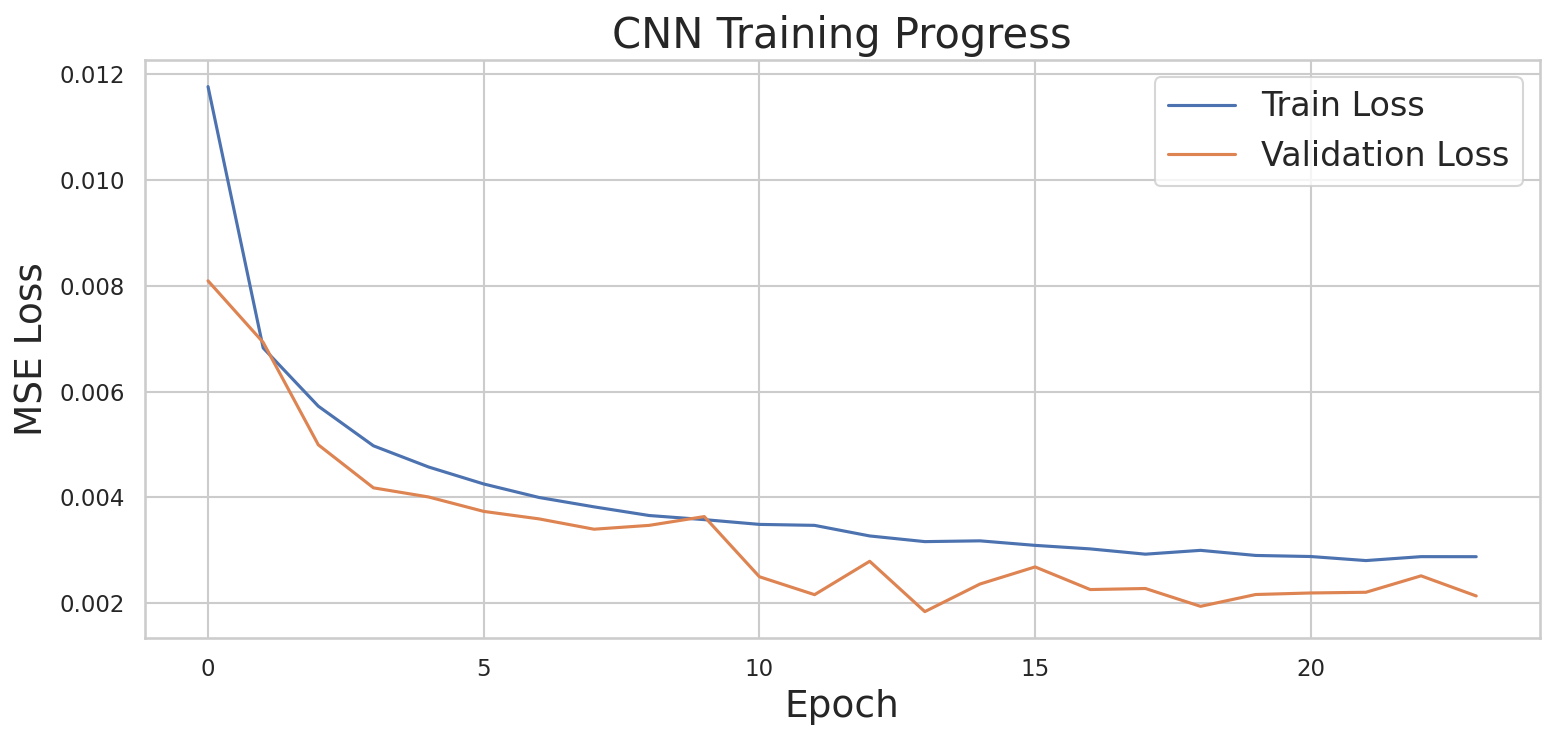

134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
📌 Validation Evaluation
MAE  = 13.9862
RMSE = 20.9046
R²   = 0.9079
--------------------------------------
📌 Test Evaluation
MAE  = 12.4748
RMSE = 16.9847
R²   = 0.8809
--------------------------------------


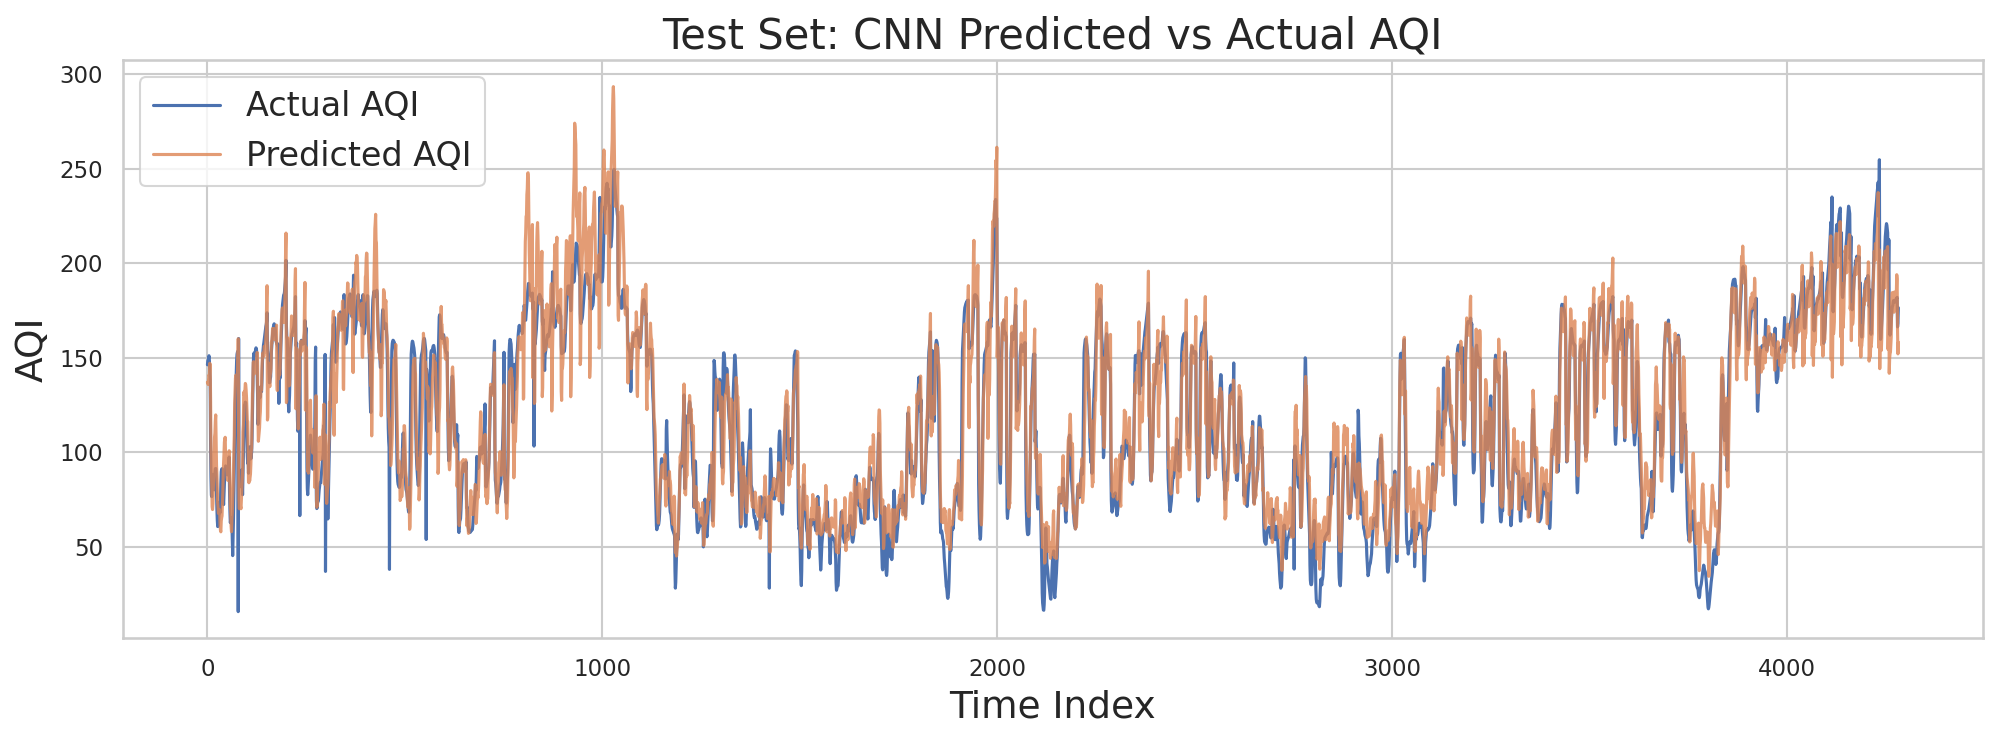

In [1]:
# ============================================
# 📌 CNN-Based AQI Forecasting (1D Conv)
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (14,6)
plt.rcParams["font.size"] = 16
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["legend.fontsize"] = 16
plt.rcParams["figure.dpi"] = 150

# Check GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# ----------------------------
# Load and preprocess dataset
# ----------------------------
df = pd.read_csv("/content/final_cleaned_interpolated.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.set_index("datetime").sort_index()
df = df.dropna()

# Feature engineering
df["hour"] = df.index.hour
df["month"] = df.index.month
df["hour_sin"] = np.sin(2 * np.pi * df["hour"]/24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"]/24)
df["month_sin"] = np.sin(2 * np.pi * df["month"]/12)
df["month_cos"] = np.cos(2 * np.pi * df["month"]/12)

feature_cols = [
    "pm2_5_ugm3", "pm10_ugm3", "co_ppm", "no2_ppb", "o3_ppm", "so2_ppb",
    "temperature_2m", "relative_humidity_2m", "surface_pressure",
    "precipitation", "cloudcover", "windspeed_10m",
    "hour", "month", "hour_sin", "hour_cos", "month_sin", "month_cos"
]

# Train/valid/test split
train_size, valid_size = 0.8, 0.1
n = len(df)
train_end = int(n * train_size)
valid_end = int(n * (train_size + valid_size))

train = df.iloc[:train_end]
valid = df.iloc[train_end:valid_end]
test  = df.iloc[valid_end:]

# Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train = scaler_X.fit_transform(train[feature_cols])
X_valid = scaler_X.transform(valid[feature_cols])
X_test  = scaler_X.transform(test[feature_cols])
y_train = scaler_y.fit_transform(train[["AQI"]])
y_valid = scaler_y.transform(valid[["AQI"]])
y_test  = scaler_y.transform(test[["AQI"]])

# Create sequences
SEQ_LEN = 24
def create_sequences(X, y, seq_len=SEQ_LEN):
    X_seq, y_seq = [], []
    for i in range(len(X)-seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train, y_train)
X_valid_seq, y_valid_seq = create_sequences(X_valid, y_valid)
X_test_seq, y_test_seq   = create_sequences(X_test, y_test)

print("Train sequence shape:", X_train_seq.shape)

# ----------------------------
# Build CNN model
# ----------------------------
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(SEQ_LEN, len(feature_cols))),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_valid_seq, y_valid_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# ----------------------------
# Plot training progress
# ----------------------------
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("CNN Training Progress")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------
# Predictions + Evaluation
# ----------------------------
def inverse_scale(y_scaled):
    return scaler_y.inverse_transform(y_scaled)

y_valid_pred = inverse_scale(model.predict(X_valid_seq))
y_test_pred  = inverse_scale(model.predict(X_test_seq))
y_valid_true = inverse_scale(y_valid_seq)
y_test_true  = inverse_scale(y_test_seq)

def evaluate(true, pred, label="Set"):
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    print(f"📌 {label} Evaluation")
    print(f"MAE  = {mae:.4f}")
    print(f"RMSE = {rmse:.4f}")
    print(f"R²   = {r2:.4f}")
    print("--------------------------------------")

evaluate(y_valid_true, y_valid_pred, "Validation")
evaluate(y_test_true, y_test_pred, "Test")

# ----------------------------
# Example: Actual vs Predicted Plot
# ----------------------------
plt.figure(figsize=(16,5))
plt.plot(y_test_true, label="Actual AQI")
plt.plot(y_test_pred, label="Predicted AQI", alpha=0.8)
plt.title("Test Set: CNN Predicted vs Actual AQI")
plt.xlabel("Time Index")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.show()
